In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli
import os
from PIL import Image
import keras
import keras.backend as K
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()




Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
# import tensorflow as tf
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)
x_train, x_test = x_train / 255.0, x_test / 255.0


In [3]:
!nvidia-smi

Tue Jun 11 13:27:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P2    27W /  N/A |    848MiB /  6078MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)
# model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

# model.__dict__

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 15s 245us/step - loss: 0.1750 - acc: 0.9474 - val_loss: 0.0536 - val_acc: 0.9832
Epoch 2/3
60000/60000 [==============================] - 11s 183us/step - loss: 0.0734 - acc: 0.9773 - val_loss: 0.0433 - val_acc: 0.9854
Epoch 3/3
10000/10000 [==============================] - 1s 50us/step


[0.03782409883702639, 0.9871]

In [5]:
f = K.function([model.layers[0].input, K.learning_phase()],
               [model.layers[-1].output])

def predict_with_uncertainty(f, x, no_classes = 10, n_iter=100):
    result = np.zeros((n_iter,) + (x.shape[0], no_classes) )

    for i in range(n_iter):
        result[i,:, :] = f((x, 1))[0]

    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty    

# from https://stackoverflow.com/questions/44971349/how-to-turn-off-dropout-for-testing-in-tensorflow/44971517

In [132]:

# np.shape(uncertainty)

In [10]:
def imshow(image):
    image = image 
#     plt.imshow(img, )  # convert from Tensor image    
    plt.imshow(np.squeeze(image), cmap='gray')  

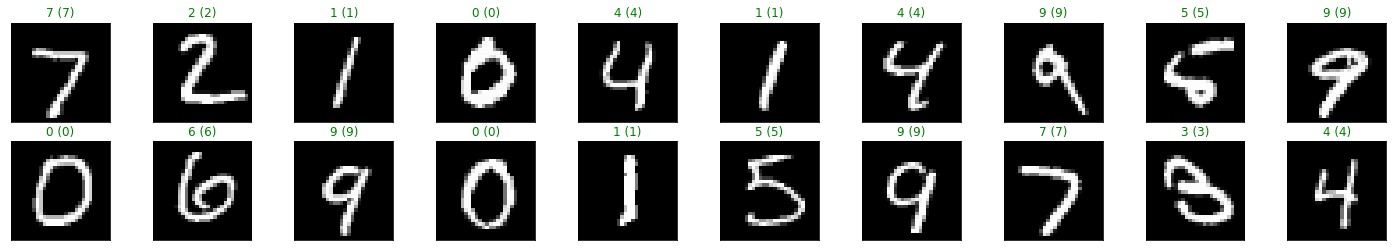

In [11]:
fig = plt.figure(figsize=(25, 4))
predict, uncertainty = predict_with_uncertainty(f, x_test[:20])

preds = [np.where(x == np.amax(x))[0][0] for x in predict]

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(x_test[idx])
#     actual = y_test[index]
    ax.set_title("{} ({})".format(preds[idx], y_test[idx]), color=("green" if preds[idx]==y_test[idx] else "red"))

label: 0 prob: 1.6922365760007295e-08 uncertainty: 5.9021304349457876e-08
label: 1 prob: 2.7421717389902658e-11 uncertainty: 7.361055680031856e-11
label: 2 prob: 6.503230827958894e-07 uncertainty: 1.4788562147752574e-06
label: 3 prob: 2.491485083466749e-06 uncertainty: 7.379424505395598e-06
label: 4 prob: 2.441294276300926e-12 uncertainty: 1.2958536668076643e-11
label: 5 prob: 1.8294622090408563e-09 uncertainty: 5.320163376388993e-09
label: 6 prob: 8.434412122482602e-16 uncertainty: 2.704043236467707e-15
label: 7 prob: 0.9999957013130188 uncertainty: 9.45950793526906e-06
label: 8 prob: 2.109616570721701e-09 uncertainty: 6.307636222556291e-09
label: 9 prob: 1.1351972818629541e-06 uncertainty: 1.9455556017045987e-06


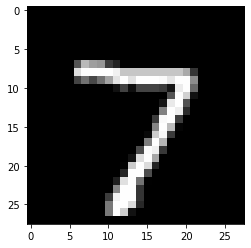

In [14]:
predict, uncertainty = predict_with_uncertainty(f, np.array([x_test[0]]))
imshow(x_test[0])
for i in range(10):
    print("label:" , i, "prob:", predict[0][i], "uncertainty:", uncertainty[0][i])

(28, 28, 1) (1,)
label: 0 prob: 0.017795972563326358 uncertainty: 0.01091936386069889
label: 1 prob: 0.029489823854528367 uncertainty: 0.024773990964809756
label: 2 prob: 0.2514818168431521 uncertainty: 0.13761307507027765
label: 3 prob: 0.09408339118584991 uncertainty: 0.07030058183797806
label: 4 prob: 0.017904139667516573 uncertainty: 0.016941671142962487
label: 5 prob: 0.22254619915038348 uncertainty: 0.12605758414122867
label: 6 prob: 0.016238170142751186 uncertainty: 0.012583856877819969
label: 7 prob: 0.09045321075245738 uncertainty: 0.06615332672076131
label: 8 prob: 0.22300497993826865 uncertainty: 0.11008434826704246
label: 9 prob: 0.037002292713150385 uncertainty: 0.023337319273563674
predicted: 2 ; value:  0.2514818168431521 ; uncertainty:  0.13761307507027765


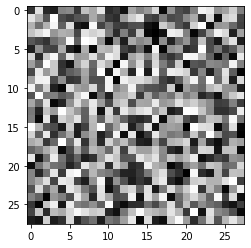

In [28]:
image = np.random.random((28,28,1))
label = np.random.randint(0,10, (1,))
print(np.shape(image), np.shape(label))

predict, uncertainty = predict_with_uncertainty(f, np.array([image]))

imshow(image)
for i in range(10):
    print("label:" , i, "prob:", predict[0][i], "uncertainty:", uncertainty[0][i])
    
print("predicted:", np.argmax(predict[0]), "; value: ", predict[0][np.argmax(predict[0])], "; uncertainty: ", uncertainty[0][np.argmax(predict[0])] )


In [231]:
# # images_random = np.rand(100,28,28)
# # labels_random = np.randint(0,10, (100,))
# images_random = np.random.random((20,28,28))
# labels_random = np.random.randint(0,10, (20,))
# # print(np.shape(images_random), np.shape(labels_random))

# fig = plt.figure(figsize=(25, 4))
# predict, uncertainty = predict_with_uncertainty(f, images_random)

# # preds = [np.where(x == np.amax(x))[0][0] for x in predict]


# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     pred = np.argmax(predict[idx])
# #     print(pred)
#     unc = uncertainty[idx][pred]
#     if unc > 0.2:
#         label = "uncertain"
#     else:
#         label = pred
#     imshow(images_random[idx])
#     ax.set_title("{} ".format(label))
# #     ax.set_title("{} ".format(np.argmax(predict[idx]), images_random[idx]), color=("green" if preds[idx]==labels_random[idx] else "red"))

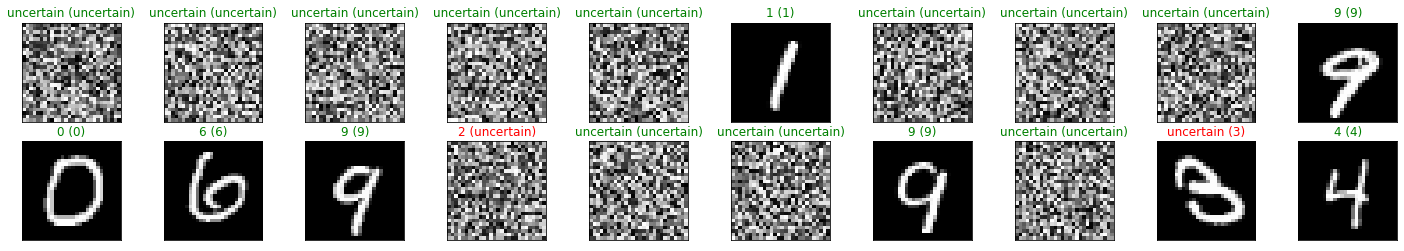

In [30]:
images = []
labels = []

for i in range(20):
    if bool(random.getrandbits(1)):
        images.append(np.random.random((28,28,1)))
        labels.append("uncertain")
    else:
        images.append(x_test[i])
        labels.append(y_test[i])

images = np.asarray(images)
labels = np.asarray(labels)
# print(np.shape(images), np.shape(labels))
predict, uncertainty = predict_with_uncertainty(f, images)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    pred = np.argmax(predict[idx])

    unc = uncertainty[idx][pred]
    if unc > 0.1:
        label = "uncertain"
    else:
        label = pred
    imshow(images[idx])
#     ax.set_title("{} ".format(label))
    ax.set_title("{} ({})".format(label, labels[idx]), color=("green" if labels[idx]==str(label) else "red"))